## Funciones Extra 

In [1]:
# function to get unique values
def unique(list1):
    # intilize a null list
    unique_list = []
    # traverse for all elements
    for x in list1:
        # check if exists in unique_list or not
        if x not in unique_list:
            unique_list.append(x)
    return unique_list

def splitClasses(string):
    return string.split('|')

def getAllDifferentClasses(dataframe, column):
    labels = xray_df[column].unique()
    anidada = [splitClasses(cs) for cs in labels]
    labels = [l for lista in anidada for l in lista]
    return unique(labels)

def getCountsDataFrame(df, column, labels):
    col = df[column]
    diccionario  = {l:0 for l in labels}
    for element in col:
        lsplit = splitClasses(element)
        #print(lsplit)
        for l_individual in lsplit:
            #print(diccionario[l_individual])
            diccionario[l_individual] += 1
    return diccionario

def getCountsColumn(col, labels):
    diccionario  = {l:0 for l in labels}
    for element in col:
        lsplit = splitClasses(element)
        #print(lsplit)
        for l_individual in lsplit:
            #print(diccionario[l_individual])
            diccionario[l_individual] += 1
    return diccionario
        
def plotCounts(counts_dict, graphWidth, name='Counts'):
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    plt.xticks(rotation='vertical')
    plt.title(name)
    plt.bar(*zip(*counts_dict.items()), color=['red', 'green', 'blue', 'cyan', 'black'])
    plt.show()
    
def countPairs(df, column, la, lb):
    col = df[column]
    suma = 0
    for element in col:
        lsplit = splitClasses(element)
        if la in lsplit and lb in lsplit:
            suma += 1
    return suma

def coOcurrencia(dataframe, column):
    #labelsmix = dataframe[column].unique()
    labels = getAllDifferentClasses(dataframe, column)
    n_labels = len(labels)
    matrix_coo = np.zeros((n_labels,n_labels))
    
    for i, la in enumerate(labels):
        max_count = 0
        normalize = False;
        for j, lb in enumerate(labels):
            #search pair (la, lb)
            count = countPairs(dataframe, 'Finding Labels', la, lb)
            matrix_coo[i][j] = count
            if count > max_count:
                max_count = count
                normalize = True
        if normalize:
            matrix_coo[i] = matrix_coo[i] * (1/max_count)
    return labels, matrix_coo

def plotCorrelationMatrix(labels, matrix, graphWidth, title='Correlation Matrix for'):
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(matrix, fignum = 1)
    plt.xticks(range(len(labels)), labels, rotation=90)
    plt.yticks(range(len(labels)), labels)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(title, fontsize=15)
    plt.show()

## Importaciones y Vista previa 

In [2]:
import pandas as pd 
import numpy as np 
from itertools import chain

import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)


In [11]:
!ls ../../raw_data/full-dataset

ARXIV_V5_CHESTXRAY.pdf	Data_Entry_2017.csv  LOG_CHESTXRAY.pdf	val_list.csv
BBox_List_2017.csv	FAQ_CHESTXRAY.pdf    test_list.csv


In [13]:
xray_df = pd.read_csv('../../raw_data/full-dataset/Data_Entry_2017.csv')

In [14]:
nRow, nCol = xray_df.shape
print(f'There are {nRow} rows and {nCol} columns')
xray_df.sample(5)

There are 112120 rows and 12 columns


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
14904,00003892_000.png,No Finding,0,3892,47,M,PA,2048,2500,0.171,0.171,NaN
27909,00007274_006.png,Nodule,6,7274,32,F,PA,2048,2500,0.168,0.168,NaN
60118,00014839_005.png,Mass,5,14839,30,F,PA,2992,2991,0.143,0.143,NaN
58967,00014596_009.png,No Finding,9,14596,53,M,AP,2500,2048,0.168,0.168,NaN
53736,00013572_012.png,No Finding,12,13572,61,F,PA,2550,2565,0.143,0.143,NaN


In [15]:
xray_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112120 entries, 0 to 112119
Data columns (total 12 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Image Index                  112120 non-null  object 
 1   Finding Labels               112120 non-null  object 
 2   Follow-up #                  112120 non-null  int64  
 3   Patient ID                   112120 non-null  int64  
 4   Patient Age                  112120 non-null  int64  
 5   Patient Gender               112120 non-null  object 
 6   View Position                112120 non-null  object 
 7   OriginalImage[Width          112120 non-null  int64  
 8   Height]                      112120 non-null  int64  
 9   OriginalImagePixelSpacing[x  112120 non-null  float64
 10  y]                           112120 non-null  float64
 11  Unnamed: 11                  0 non-null       float64
dtypes: float64(3), int64(5), object(4)
memory usage: 10.3+ MB


In [16]:
# La columna no contiene nada 
xray_df.drop(columns= 'Unnamed: 11', inplace=True )

## Encoding
El conjunto de datos de NIH contiene ejemplos de diversas enfermedades, todas estas estan reportadas en la columna Findings Labels.se agregará una columna binaria para cada enfermedad, esto facilita el análisis y entrenamiento.


In [17]:
# Generacion columna conteo de enfermedades por imagen 
xray_df['count_diseases'] = xray_df['Finding Labels'].map(lambda x: len(x.split('|')))

In [18]:
all_labels = np.unique(list(chain(*xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]

print('All Labels ({}): {}'.format(len(all_labels), all_labels))


All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


In [19]:
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        xray_df[c_label] = xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)

xray_df.sample(3)    

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],count_diseases,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
8839,00002337_000.png,Fibrosis,0,2337,54,M,PA,2500,2048,0.168,0.168,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15658,00004116_000.png,No Finding,0,4116,49,M,PA,2048,2500,0.171,0.171,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
6222,00001684_023.png,Atelectasis,23,1684,58,M,AP,2500,2048,0.168,0.168,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Estudio de la población


### EDAD 

Average poblation age:  46.90146271851587
Younger patient: 1
Older patient 414


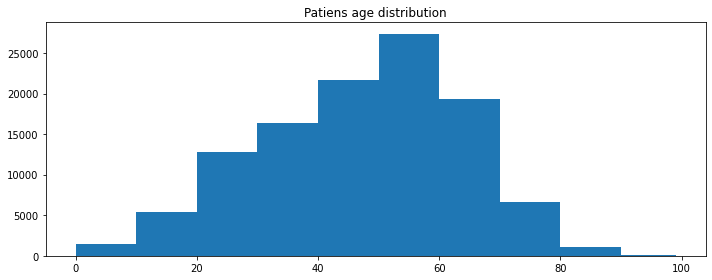

In [20]:
# Get average Age
ages = xray_df['Patient Age']

average_age = np.average(ages)
print("Average poblation age: ", average_age)
print("Younger patient:", np.min(ages))
print("Older patient", np.amax(ages))

fig = plt.subplots(figsize = (10, 4))

plt.subplot(1, 1,1)
plt.subplots_adjust(hspace = 1.0)
ax = plt.hist(ages, bins=[0,10,20,30,40,50,60,70,80,90,99])
plt.title('Patiens age distribution')
plt.tight_layout()

In [21]:
df_mayor100 = xray_df[xray_df['Patient Age'] > 100]
index_mayor100 = list(df_mayor100.index)
print('Cantidad de pacientes mayores a 100 años : ',df_mayor100.shape[0])

Cantidad de pacientes mayores a 100 años :  16


In [22]:
#drop años sin sentido 
xray_df = xray_df.drop(index_mayor100)

['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax'] 

Average poblation age:  46.06583663459725
Younger patient: 2
Older patient 152


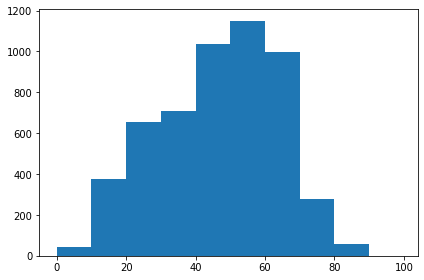

In [23]:
# Imprimir distribucion de la enfermedad por edad 
print(all_labels,'\n')
with_disease = np.array(xray_df['Pneumothorax'])
indexes = np.where(with_disease==1)[0]
ages_pneu = ages[list(indexes)]

print("Average poblation age: ", np.average(ages_pneu))
print("Younger patient:", np.min(ages_pneu))
print("Older patient", np.amax(ages_pneu))


plt.hist(ages_pneu, bins=[0,10,20,30,40,50,60,70,80,90,99])
plt.tight_layout()

#### Conclusiones
1. Eliminar los pacientes mayores a 100

### Genero

In [24]:
xray_df['Patient Gender'].value_counts()

M    63328
F    48776
Name: Patient Gender, dtype: int64

Cantidad pacientes NO enfermos: 60353


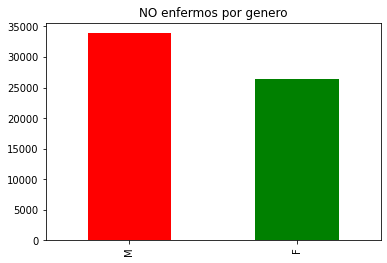

In [25]:
no_enfermos = xray_df[xray_df['No Finding'] == 1]
index_no_enfermos = list(no_enfermos.index)
print('Cantidad pacientes NO enfermos:', no_enfermos.shape[0])
no_enfermos = no_enfermos['Patient Gender'].value_counts()
plt.title('NO enfermos por genero')
no_enfermos.plot(kind = 'bar',color=['red', 'green']);

Cantidad pacientes enfermos: 51751


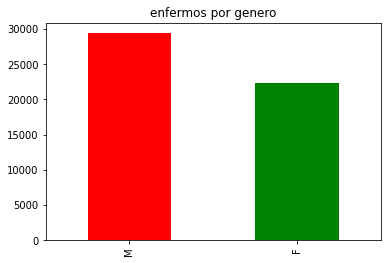

In [26]:
enfermos = xray_df.drop(index_no_enfermos)
print('Cantidad pacientes enfermos:', enfermos.shape[0])
plot_genero = enfermos['Patient Gender'].value_counts()
plt.title('enfermos por genero')
plot_genero.plot(kind = 'bar',color=['red', 'green']);

['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax'] 



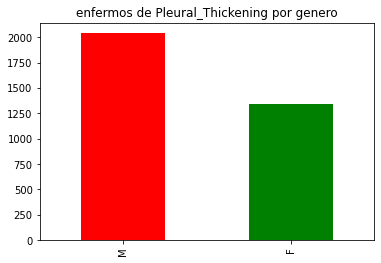

In [27]:
genero = xray_df['Patient Gender']
print(all_labels,'\n')

disease = 'Pleural_Thickening'
with_disease = xray_df[xray_df[disease]==1]
plot_disease = with_disease['Patient Gender'].value_counts()
plt.title(f'enfermos de {disease} por genero')
plot_disease.plot(kind = 'bar',color=['red', 'green']);

#### Conclusiones 
1. Hay mas masculino tanto en los enfermos como en los No enfermos 

### Distribución de las enfermedades halladas


In [28]:
print(all_labels)

['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


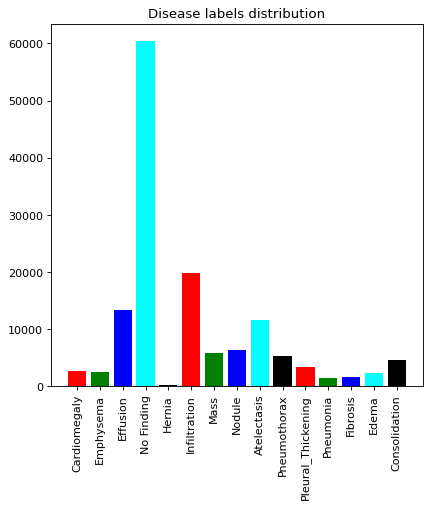

Conteo de Hernia: 227


In [29]:
# Plot disease labels distribution
column = 'Finding Labels'
labels = getAllDifferentClasses(xray_df, column)
dict_counts = getCountsDataFrame(xray_df, column, labels)

plotCounts(dict_counts, 6, name= 'Disease labels distribution')

disease = 'Hernia'

print(f'Conteo de {disease}:', dict_counts[disease])

In [30]:
no_enfermos = xray_df[xray_df['No Finding'] == 1]
enfermos = xray_df.drop(index_no_enfermos)

In [31]:
print('NO enfermos:',no_enfermos.shape[0],'\n','Enfermos:',enfermos.shape[0])
no_enfermos.shape[0]+enfermos.shape[0] 

NO enfermos: 60353 
 Enfermos: 51751


112104

In [32]:
values = list(dict_counts.values())
myInt = xray_df.shape[0]
keys = list(dict_counts.keys())

porcentaje = []
for x in values:
    porcentaje.append(x/myInt)


In [34]:
# for p in porcentaje:
#     for 
#     dict

#### Conclusiones 
1.  Habra que  unificar algunas enfermedades o balancear el Dataset 
2. Clases desequilibradas en términos de hallazgos, la clase mayoritaria de "sin hallazgos" puede ser más de diez veces el número de ejemplos de la clase de neumonía. Por lo tanto, tenemos algunas técnicas para abordar el problema del desequilibrio, por ejemplo, en la etapa de entrenamiento, se puede hacer un sub-conjunto de datos balanceado usando submuestreo.
3. porcentaje sobre el total FALTANTE 

##  Distribución de las posiciones de vista


En las vistas **anteroposteriores (AP)**, las posiciones de la fuente y detector de rayos X son revertidas: los rayos X ingresan por el aspecto anterior y egresan por el aspecto posterior del tórax. **DELANTE HACIA ATRAS**

En una vista **posteroanterior (PA)**, la fuente de rayos X se halla posicionada de manera tal que los rayos X ingresan por el aspecto posterior (espalda) del tórax y regresan por el aspecto anterior (frontal) donde los mismos son detectados. **ATRAS HACIA ADELANTE**

['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax'] 



AP    44805
PA    67299
Name: View Position, dtype: int64

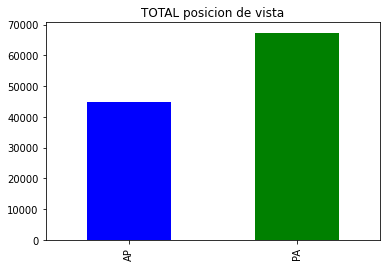

In [35]:
genero = xray_df['View Position']
print(all_labels,'\n')

plot_total = genero.value_counts().sort_index()
plt.title(f'TOTAL posicion de vista')
plot_total.plot(kind = 'bar',color=['blue', 'green']);

plot_total

['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax'] 



AP    6727
PA    6589
Name: View Position, dtype: int64

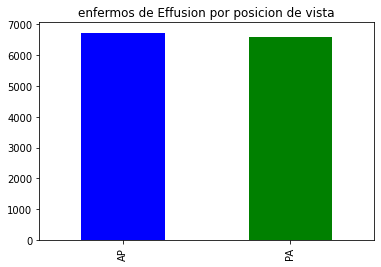

In [36]:
genero = xray_df['View Position']
print(all_labels,'\n')

disease = 'Effusion'
with_disease = xray_df[xray_df[disease]==1]
plot_disease = with_disease['View Position'].value_counts().sort_index()
plt.title(f'enfermos de {disease} por posicion de vista')
plot_disease.plot(kind = 'bar', color=['blue', 'green']);

with_disease['View Position'].value_counts()

## Enfermedades X paciente  y Comorbilidad 


In [37]:
no_enfermos = xray_df[xray_df['No Finding'] == 1]
enfermos = xray_df.drop(index_no_enfermos)

1    60353
Name: count_diseases, dtype: int64

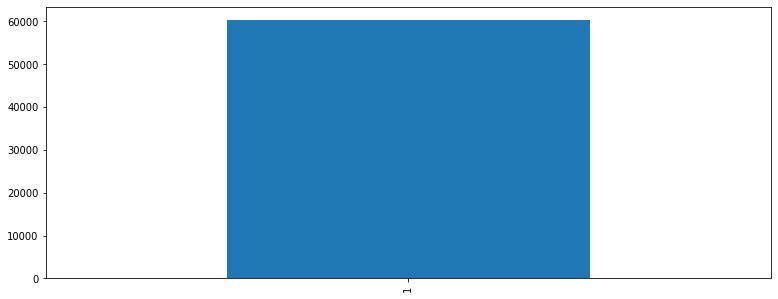

In [38]:
no_enfermos_plot = no_enfermos['count_diseases'].value_counts()
plt.figure(figsize=(13,5))
no_enfermos_plot.plot(kind = 'bar');
no_enfermos_plot

1    30959
2    14302
3     4856
4     1247
5      301
6       67
7       16
9        2
8        1
Name: count_diseases, dtype: int64

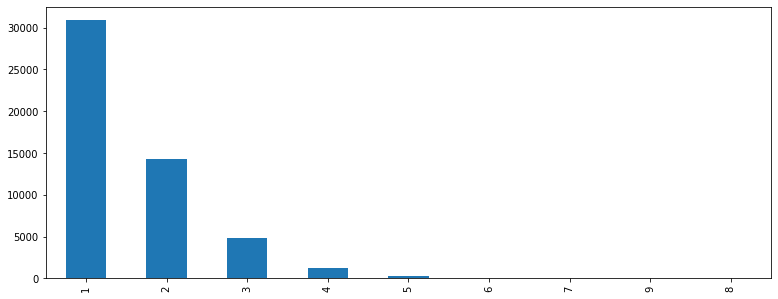

In [39]:
disease_paciente = enfermos['count_diseases'].value_counts()
plt.figure(figsize=(13,5))
disease_paciente.plot(kind = 'bar');
disease_paciente

In [40]:
df = enfermos[enfermos['count_diseases']==2]
df_2 = df['Finding Labels'].value_counts().to_frame()
df_2[df_2['Finding Labels'] > 200]

,Finding Labels
Effusion|Infiltration,1603
Atelectasis|Infiltration,1350
Atelectasis|Effusion,1165
Infiltration|Nodule,829
Cardiomegaly|Effusion,484
Consolidation|Infiltration,441
Infiltration|Mass,418
Effusion|Pneumothorax,403
Effusion|Mass,402
Atelectasis|Consolidation,398


In [41]:
xray_df[xray_df['Finding Labels']=='Infiltration|Effusion']

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],count_diseases,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
69491,00017138_037.png,Infiltration|Effusion,37,17138,24,M,AP,2500,2048,0.168,0.168,2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


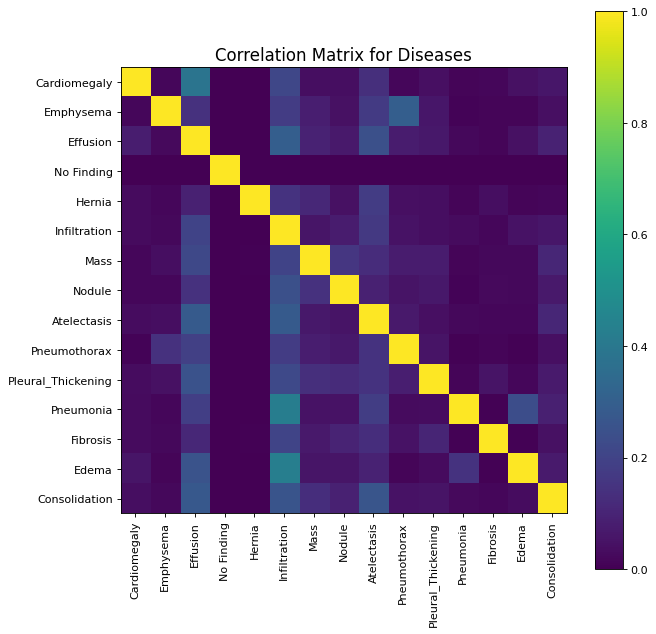

In [42]:
column = 'Finding Labels'
labels, matco = coOcurrencia(xray_df, column)
plotCorrelationMatrix(labels, matco, 9, title = 'Correlation Matrix for Diseases')